# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [16]:
import homework_l7_backend as l7bk
import os
import json
from glob import glob
import sys
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

# Загружаем разметку

In [17]:
l7bk.IMG_HEIGHT = 468
l7bk.IMG_WIDTH = 752
#label_encoder, str_labels = l7bk.make_labels(["NoF"])
label_encoder, str_labels = l7bk.make_labels([])
print(str_labels)
print(label_encoder)

['BET', 'DOL', 'ALB', 'LAG', 'SHARK', 'YFT']
{'BET': [0, 1, 0, 0, 0, 0], 'DOL': [0, 0, 1, 0, 0, 0], 'ALB': [1, 0, 0, 0, 0, 0], 'LAG': [0, 0, 0, 1, 0, 0], 'SHARK': [0, 0, 0, 0, 1, 0], 'YFT': [0, 0, 0, 0, 0, 1]}


### Визуализируем разметку

In [18]:
boxes = l7bk.load_boxes()  # разметка детекций
nofiles = l7bk.load_NoFiles()

In [19]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,bet,200
1,dol,117
2,alb,1719
3,lag,67
4,shark,176
5,yft,734


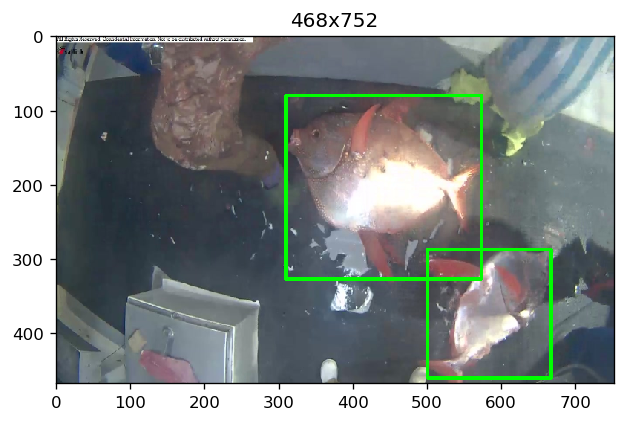

In [20]:
plt.figure(figsize=(6, 6), dpi=120)
img = l7bk.draw_boxes(boxes['lag'][17],image_size=(l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

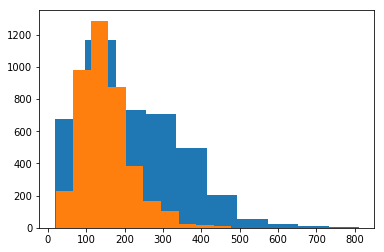

In [21]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

# Сетка якорей (anchor grid)

In [22]:
#with tf.device('/device:CPU:0'):
#    features = l7bk.get_feature_tensor()
l7bk.set_tensor_shape()
#output = features.layers[-1].output

In [23]:


def nof_anchors():
    encoded = np.zeros(shape=(l7bk.FEATURE_SHAPE[0],
                              l7bk.FEATURE_SHAPE[1], len(str_labels) ), dtype=np.float32)
    label = "NoF"
    for row in range(l7bk.FEATURE_SHAPE[0]):
        for col in range(l7bk.FEATURE_SHAPE[1]):
            dx = 0 ; dy = 0
            dw = 0 ; dh = 0
            encoded[row, col] = [1., dx, dy, dw, dh] + label_encoder[label]
    return encoded

### Валидация енкодинга/декодинга

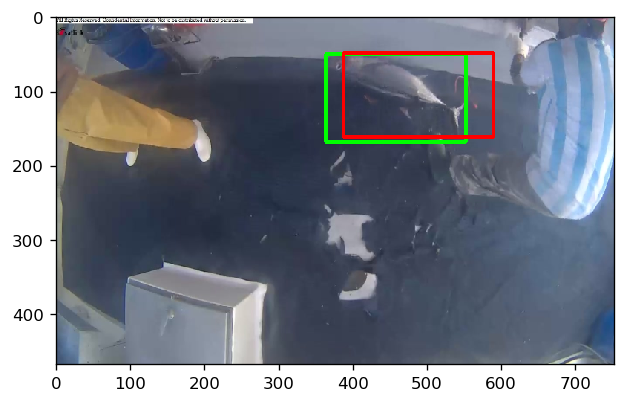

In [24]:
example = boxes['alb'][175]

encoded = l7bk.encode_anchors(example, (l7bk.IMG_HEIGHT, l7bk.IMG_WIDTH))

decoded = l7bk.decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(l7bk.draw_boxes(example, decoded[:10], 
                           image_size=(l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT)))

batch_loss_arr = tf.Variable(0.0)

## Функция потерь

In [25]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    #return tf.constant(-0.0)*y_pred
    #return confidence_loss(0.5, 1)
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss
    #return  tf.cond(tf.equal(K.shape(y_true)[1], tf.constant(6)), 
    #               lambda: tf.constant(-0.0)*y_pred, 
    #               lambda: conf_loss)
    

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:5] - y_pred[..., 1:5])
    square_loss = 0.5 * K.square(y_true[..., 1:5] - y_pred[..., 1:5])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)
copyten = 111

       
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    pos_mask =  y_true[...,5] == 0
    
    y_true_pos = tf.boolean_mask(y_true,y_true[...,0])
    y_pred_pos = tf.boolean_mask(y_pred,y_true[...,0])
    class_loss = K.categorical_crossentropy(y_true_pos[...,5:], 
                                                y_pred_pos[...,5:],
                                                from_logits=True,
                                                axis=-1)
    class_loss = K.mean(class_loss)
    #pos_class_loss = K.sum(class_loss * y_true[..., 0], axis=-1)
    pos_class_loss = K.mean(class_loss)
    # confidence loss
    conf_loss = K.mean(confidence_loss(y_true, y_pred))
    
    conf_loss = 0.5*conf_loss + 0.5*pos_class_loss

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    result = total_conf_loss + 0.5 * loc_loss
    global batch_loss_arr
    batch_loss_arr = tf.cond(tf.equal(tf.rank(batch_loss_arr) ,tf.rank(result)), 
    lambda: (result +  batch_loss_arr)/2,
    lambda: result)
    return batch_loss_arr
#def debug_loss(y_true, y_pred, neg_pos_ratio=3):
#    return tf.cond(tf.equal(tf.size(y_true), tf.constant(6)), 
#                   lambda: tf.constant(0.1)*y_pred, 
#                   lambda: total_loss(y_pred, y_true, neg_pos_ratio))
def debug_loss(y_true, y_pred, neg_pos_ratio=3):
    def debug_loss2(y_true, y_pred, neg_pos_ratio=3):
        batch_size = K.shape(y_true)[0]
        #resultten = tf.zeros_like(y_pred)*y_pred
        y_pred = tf.reshape(y_pred, (batch_size, -1,5 + len(str_labels)))
        y_true = K.reshape(y_true, (batch_size, -1, 5 + len(str_labels)))
        #rrr = tf.constant([0,0,0])#y_true([0])
        #yy_true = y_true[0,0,...]
        print_op = tf.print("y_true: ", K.shape(y_true),"y_pred: ", K.shape(y_pred))
        #print_op = tf.print("y_true: ", y_true[2])
        #y_true = K.reshape(y_true, (batch_size, -1, 5))
        print_op = tf.print("y_true: ", K.shape(y_true),"y_pred: ", K.shape(y_pred))
        with tf.control_dependencies([print_op]):
            return tf.zeros_like(y_pred)*y_pred
    return debug_loss2(y_true, y_pred, neg_pos_ratio)

## Загрузка данных

In [26]:
if True:
    #with tf.device('/device:GPU:0'):
    model = keras.models.load_model('model3-fishes-vgg16.hdf5', 
                                    custom_objects={'total_loss': total_loss})

/home/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Результат работы детектора

[1.95870519e-01 6.97446242e-02 2.31768474e-01 9.98933017e-01
 2.15846296e-06 1.06698275e-03 1.43609017e-01 1.26959041e-01]


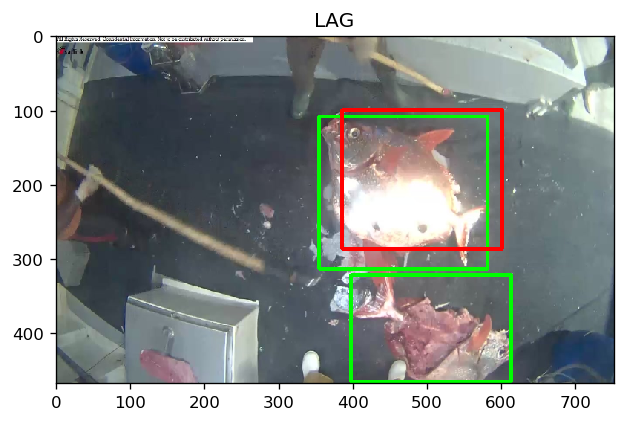

In [27]:
if True:
    example = boxes['lag'][7]

    _, sample_img = l7bk.load_img(example['filename'])
    #with tf.device('/device:GPU:0'):
    pred = model.predict(np.array([sample_img,]))[0]

    decoded = l7bk.decode_prediction(pred, conf_thr=0.0)
    decoded = sorted(decoded, key=lambda e: -e['conf'])

    plt.figure(figsize=(6, 6), dpi=120)
    img = l7bk.draw_boxes(example, decoded[:3], (l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT))
    plt.imshow(img)
    #plt.title('{}x{}'.format(*img.shape));
    print(decoded[0]['class_probab'])
    plt.title(decoded[0]['class_name'][0]);

## Агрегация результатов

In [28]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [29]:
def make_table1():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG',
                                   'NoF', 'OTHER', 'SHARK','YFT'])
    for i, file in enumerate(glob('../input/the-nature-conservancy-fisheries-monitoring/test_stg1/*.jpg')):
        bn = os.path.basename(file)
        #bn = "test_stg1/" + bn
        _, sample_img = load_img(file)
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.5)
        predictions = decoded[0]['class_probab']#[0, 1, 0, 1, 0, 1, 0, 1]
        print(i,predictions)
        pred_str = [str(ps) for ps in predictions]
        ptable.loc[len(ptable)] = [bn] + pred_str
    return ptable        
def make_table2():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG',
                               'NoF', 'OTHER', 'SHARK','YFT'])
    for i, file in enumerate(glob('../input/test-stg2/test_stg2/test_stg2/*.jpg')):
        bn = os.path.basename(file)
        #bn = "test_stg2/" + bn
        _, sample_img = load_img(file)
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.5)
        predictions = decoded[0]['class_probab']#[0, 1, 0, 1, 0, 1, 0, 1]
        print(i,predictions)
        pred_str = [str(ps) for ps in predictions]
        ptable.loc[len(ptable)] = [bn] + pred_str
    return ptable

if True:
    print("start_predictions")
    pred_table1 = make_table1()
    pred_table1.to_csv("netol_submit_stg1.csv", index=False)
    pred_table2 = make_table2()
    pred_table2.to_csv("netol_submit_stg2.csv", index=False)

0 [0.99649626 0.6321426  0.24431619 0.11516124 0.01586067 0.00350374
 0.14431168 0.45519063]
1 [9.99382734e-01 2.34199420e-01 9.18810666e-02 1.50033176e-01
 1.15916614e-06 6.17265701e-04 1.90315545e-01 3.76080751e-01]
2 [5.11077158e-02 6.50432944e-01 1.35354489e-01 1.37903035e-01
 3.72864191e-05 3.70740891e-05 8.22674930e-02 9.99962926e-01]
3 [9.99030113e-01 3.40561926e-01 2.02628553e-01 2.01144978e-01
 1.42430248e-02 9.69886780e-04 1.99279353e-01 1.77189693e-01]
4 [9.96085644e-01 9.54491615e-01 9.88878459e-02 5.29309437e-02
 1.09169677e-05 3.91435623e-03 3.29857230e-01 1.87173858e-01]
5 [0.75956923 0.39854982 0.13963814 0.28019035 0.06546704 0.0104757
 0.24422878 0.9895243 ]
6 [1.17902257e-01 4.22872484e-01 1.04535714e-01 1.72861159e-01
 6.64953648e-10 1.28626823e-04 1.34698495e-01 9.99871373e-01]
7 [9.99556482e-01 1.27746105e-01 9.64652225e-02 1.53889656e-01
 5.48459950e-08 4.43518162e-04 1.61643028e-01 5.59515417e-01]
8 [0.61917138 0.28165093 0.26219606 0.25342217 0.21117057 0.01914

68 [9.99754488e-01 3.99062634e-01 1.04945153e-01 1.00071281e-01
 2.81564737e-08 2.45511532e-04 2.06102923e-01 1.97166279e-01]
69 [9.99972224e-01 7.87532777e-02 6.14303499e-02 1.05756499e-01
 2.38498110e-12 2.77757645e-05 1.91530719e-01 2.65479505e-01]
70 [9.97745812e-01 6.90935552e-02 1.70578480e-01 4.53751683e-01
 1.01490864e-04 2.25418806e-03 1.57190919e-01 3.74814749e-01]
71 [9.99992967e-01 4.26211767e-02 7.62090683e-02 1.29422516e-01
 2.46765554e-08 7.03334808e-06 2.09573492e-01 1.53875813e-01]
72 [7.92410433e-01 8.65818024e-01 1.23150900e-01 9.94788706e-02
 5.41684178e-04 3.73594165e-02 2.23156065e-01 9.62640584e-01]
73 [9.99836445e-01 1.57362759e-01 8.67845267e-02 2.15701163e-01
 4.81858815e-07 1.63555145e-04 1.66363999e-01 2.29942203e-01]
74 [5.27467489e-01 1.13687083e-01 2.57603437e-01 8.22307840e-02
 1.18466773e-07 2.69830227e-04 1.82440579e-01 9.99730170e-01]
75 [3.93223554e-01 1.34861320e-01 8.66040438e-02 4.35616344e-01
 1.56577238e-08 2.56818533e-03 2.50038564e-01 9.974318

KeyboardInterrupt: 